In [8]:
import requests
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, roc_curve

In [3]:
with open('../data/pickledcooking.pkl','rb') as x:
    df_cook = pickle.load(x)

In [4]:
with open('../data/pickledbeginners.pkl','rb') as x:
    df_cforb = pickle.load(x)

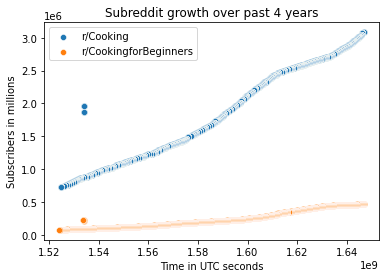

In [11]:
sns.scatterplot(data=df_cook,x='created_utc',y='subreddit_subscribers')
sns.scatterplot(data=df_cforb,x='created_utc',y='subreddit_subscribers')
plt.xlabel('Time in UTC seconds')
plt.ylabel('Subscribers in millions')
plt.title('Subreddit growth over past 4 years')
plt.legend(['r/Cooking','r/CookingforBeginners'])
plt.show()

In [5]:
df_cforb['domain'].value_counts(normalize=True)

self.cookingforbeginners    0.786821
i.redd.it                   0.067325
youtu.be                    0.060546
youtube.com                 0.041594
imgur.com                   0.002951
                              ...   
megadealerships.com         0.000046
campbells.com               0.000046
questionocean.com           0.000046
bnnbloomberg.ca             0.000046
simmyideas.com              0.000046
Name: domain, Length: 371, dtype: float64

In [6]:
df_cook['domain'].value_counts(normalize=True)

self.Cooking                0.994184
rg4amia.wordpress.com       0.000785
self.AskCulinary            0.000692
self.limitlessallergies     0.000415
self.cookingforbeginners    0.000185
                              ...   
self.suggestmearecipe       0.000046
self.PressureCooking        0.000046
self.KitchenConfidential    0.000046
self.sushi                  0.000046
self.Frugal                 0.000046
Name: domain, Length: 70, dtype: float64

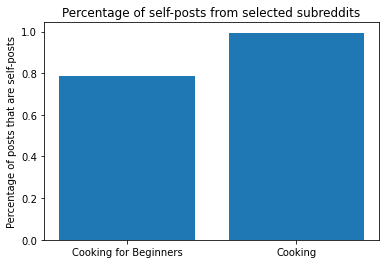

In [17]:
plt.bar(x=[1,2],height=[0.786821,0.994184])
plt.xticks([1,2],['Cooking for Beginners','Cooking'])
plt.ylabel('Percentage of posts that are self-posts')
plt.title('Percentage of self-posts from selected subreddits');

Right now, all of this information is for testing some things. It's interesting that r/cooking has had more robust growth, even relative to its size when compared to r/cookingforbeginners. Along with this, they have or recently put in place a rule of only allowing self-posts (it's implausible that 99.4% of posts would be selfs otherwise, especially when an informal look at reddit suggests that image/video posts tend to do better. Also, there are some cross-posts like suggestmearecipe or kitchenconfidential)

In [7]:
df_cook.columns

Index(['created_utc', 'domain', 'selftext', 'subreddit_subscribers', 'title'], dtype='object')

In [8]:
df_cook['selftext'].value_counts(normalize=True)

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          0.154308
                                                                                                                                                                                                                                                                                                                                                                                            

In [9]:
df_cforb['selftext'].value_counts(normalize=True)

15.4% removed (by mods/admins) on cooking versus 22.7% on CforB, and 6.85% removed by creator on cooking versus14.8% on CforB. These are all interesting ideas. Let's try to focus on only self-text (or at least primarily so) in this notebook. Figuring out how to integrate for instance, the title in a vectorized way should be interesting, along with all the other features we dragged along and comments, but those also take extra effort in processing. Let's stick to just selftext for now

In [10]:
df_cook.isnull().sum(), df_cforb.isnull().sum()

(created_utc               0
 domain                    0
 selftext                 32
 subreddit_subscribers     0
 title                     0
 dtype: int64,
 created_utc               0
 domain                    0
 selftext                 60
 subreddit_subscribers     0
 title                     0
 dtype: int64)

While we have nulls, that too can be information on the class. We won't remove them, or if need be, we'll fill them with ''

The one thing we need is a class marker so that we can actually work with these

In [18]:
df_cook['sub'] = 'r/Cooking'

In [19]:
df_cforb['sub'] = 'r/Cookingforbeginners'

In [20]:
textdata = pd.concat([df_cook[['selftext','sub']],df_cforb[['selftext','sub']]])

In [21]:
X = textdata['selftext']
y = textdata['sub']

In [22]:
X.fillna('',inplace=True)

In [23]:
y.value_counts(normalize=True)

r/Cookingforbeginners    0.500254
r/Cooking                0.499746
Name: sub, dtype: float64

Null Model- about as even as you can get!

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=815,stratify=y)

In [25]:
pipe1 = Pipeline([
    ('cv',CountVectorizer(strip_accents='unicode',ngram_range=(1,1),max_features=None)),
    ('logreg',LogisticRegression(penalty='l2'))#just calling some of these so you keep them in mind
])

In [26]:
pipe1.fit(X_train,y_train)
pipe1.score(X_test,y_test)

C:\Users\Karthik\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6164421479977855

So one of our simplest models got a score of 61.6%-we'll want to look more carefully into all our options, but this is at least a starting point

In [20]:
pipe2 = Pipeline([
    ('cv', CountVectorizer()),
    ('rfc', RandomForestClassifier(n_jobs=-1,random_state=815))
])

In [22]:
pipe2.get_params()

{'memory': None,
 'steps': [('cv', CountVectorizer()),
  ('rfc', RandomForestClassifier(n_jobs=-1, random_state=815))],
 'verbose': False,
 'cv': CountVectorizer(),
 'rfc': RandomForestClassifier(n_jobs=-1, random_state=815),
 'cv__analyzer': 'word',
 'cv__binary': False,
 'cv__decode_error': 'strict',
 'cv__dtype': numpy.int64,
 'cv__encoding': 'utf-8',
 'cv__input': 'content',
 'cv__lowercase': True,
 'cv__max_df': 1.0,
 'cv__max_features': None,
 'cv__min_df': 1,
 'cv__ngram_range': (1, 1),
 'cv__preprocessor': None,
 'cv__stop_words': None,
 'cv__strip_accents': None,
 'cv__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cv__tokenizer': None,
 'cv__vocabulary': None,
 'rfc__bootstrap': True,
 'rfc__ccp_alpha': 0.0,
 'rfc__class_weight': None,
 'rfc__criterion': 'gini',
 'rfc__max_depth': None,
 'rfc__max_features': 'auto',
 'rfc__max_leaf_nodes': None,
 'rfc__max_samples': None,
 'rfc__min_impurity_decrease': 0.0,
 'rfc__min_samples_leaf': 1,
 'rfc__min_samples_split': 2,
 'rfc__min_weight_

In [27]:
params2 = {
    'cv__max_df' : [0.8,0.9,1],
    'cv__ngram_range' : [(1,1),(1,2),(2,2)],
    'cv__strip_accents' : ['ascii','unicode'],
    'cv__max_features' : [None,1000,750],
    'rfc__ccp_alpha' :[0.0,0.5,1],
    'rfc__min_samples_leaf' : [1,2,3,5],
    'rfc__n_estimators' : [75,100,200]
} #>1800 possibilities! let's try and run through only a couple of times
rsc = RandomizedSearchCV(pipe2,param_distributions=params2,n_iter=60,n_jobs=-1)

In [28]:
rsc.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                             ('rfc',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=815))]),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'cv__max_df': [0.8, 0.9, 1],
                                        'cv__max_features': [None, 1000, 750],
                                        'cv__ngram_range': [(1, 1), (1, 2),
                                                            (2, 2)],
                                        'cv__strip_accents': ['ascii',
                                                              'unicode'],
                                        'rfc__ccp_alpha': [0.0, 0.5, 1],
                                        'rfc__min_samples_leaf': [1, 2, 3, 5],
                                        'rfc__n_estimators': [75, 100, 20

This took hours to run. In the future, I'll be more cautious, but more importantly now, I want to pickle the rsc so I can use it later

In [29]:
with open('../data/RandForestrcvpickle.pkl', 'wb') as pickle_out:
    pickle.dump(rsc,pickle_out)

...But not that cautious, as I have some time away from keyboard, and would like to run an extra trees model

In [30]:
pipe3 = Pipeline([
    ('cv', CountVectorizer()),
    ('etc', ExtraTreesClassifier(n_jobs=-1,random_state=815))
])

In [32]:
params3 = {
    'cv__max_df' : [0.8,0.9,1],
    'cv__ngram_range' : [(1,1),(1,2),(2,2)],
    'cv__strip_accents' : ['ascii','unicode'],
    'cv__max_features' : [None,1000,750],
    'etc__max_features' : ['auto','log2'],
    'etc__ccp_alpha' : [0.0,0.5,1],
    'etc__min_samples_split' : [2,3,4,5],
    'etc__criterion' : ['gini','entropy'],
    'etc__n_estimators' : [100,50,200,75]
}
rsc2 = RandomizedSearchCV(pipe3, param_distributions=params3,n_iter=60,n_jobs=-1)

In [33]:
rsc2.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                             ('etc',
                                              ExtraTreesClassifier(n_jobs=-1,
                                                                   random_state=815))]),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'cv__max_df': [0.8, 0.9, 1],
                                        'cv__max_features': [None, 1000, 750],
                                        'cv__ngram_range': [(1, 1), (1, 2),
                                                            (2, 2)],
                                        'cv__strip_accents': ['ascii',
                                                              'unicode'],
                                        'etc__ccp_alpha': [0.0, 0.5, 1],
                                        'etc__criterion': ['gini', 'entropy'],
                                        'etc__max_features': ['auto', 'log2']

In [34]:
with open('../data/ExtraPickledForestrcv.pkl', 'wb') as pickle_out:
    pickle.dump(rsc2,pickle_out)

In [35]:
rsc.score(X_test,y_test), rsc2.score(X_test,y_test)

(0.625576674663222, 0.6325890385680015)

A lot of work for not a lot of gain

In [36]:
rsc.best_params_

{'rfc__n_estimators': 200,
 'rfc__min_samples_leaf': 2,
 'rfc__ccp_alpha': 0.0,
 'cv__strip_accents': 'ascii',
 'cv__ngram_range': (1, 2),
 'cv__max_features': 1000,
 'cv__max_df': 0.8}

In [39]:
rsc2.best_params_

{'etc__n_estimators': 200,
 'etc__min_samples_split': 3,
 'etc__max_features': 'auto',
 'etc__criterion': 'entropy',
 'etc__ccp_alpha': 0.0,
 'cv__strip_accents': 'ascii',
 'cv__ngram_range': (1, 1),
 'cv__max_features': 1000,
 'cv__max_df': 0.8}

It seems that more estimators, slightly larger min splits, no CCP alpha, ascii strip accents, and a max_df/ max_features all perform well. To be more sure, we could check all the parameters searched and in particular the top couple to see if they shared features, and what can be made of them

In [46]:
pd.DataFrame(rsc2.cv_results_).sort_values(by='mean_test_score',ascending=False).head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_etc__n_estimators,param_etc__min_samples_split,param_etc__max_features,param_etc__criterion,param_etc__ccp_alpha,param_cv__strip_accents,...,param_cv__max_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
30,182.299128,12.506256,3.975812,0.509577,200,3,auto,entropy,0.0,ascii,...,0.8,"{'etc__n_estimators': 200, 'etc__min_samples_s...",0.622482,0.623251,0.626576,0.627038,0.619194,0.623708,0.002878,1
48,105.817301,8.104324,5.067628,1.166393,100,2,log2,entropy,0.0,unicode,...,0.9,"{'etc__n_estimators': 100, 'etc__min_samples_s...",0.609872,0.615870,0.611812,0.616580,0.614888,0.613804,0.002552,2
31,46.074320,4.641313,4.501480,1.110105,75,3,log2,entropy,0.0,unicode,...,0.9,"{'etc__n_estimators': 75, 'etc__min_samples_sp...",0.609719,0.617254,0.611197,0.612119,0.617964,0.613650,0.003329,3
20,464.976246,30.019388,6.308181,1.416781,75,4,auto,entropy,0.0,unicode,...,0.8,"{'etc__n_estimators': 75, 'etc__min_samples_sp...",0.613409,0.607566,0.611658,0.618118,0.613965,0.612943,0.003424,4


In [47]:
pd.DataFrame(rsc.cv_results_).sort_values(by='mean_test_score',ascending=False).head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__n_estimators,param_rfc__min_samples_leaf,param_rfc__ccp_alpha,param_cv__strip_accents,param_cv__ngram_range,param_cv__max_features,param_cv__max_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,142.842152,4.763248,5.159996,1.307765,200,2,0.0,ascii,"(1, 2)",1000,0.8,"{'rfc__n_estimators': 200, 'rfc__min_samples_l...",0.623405,0.618638,0.624269,0.611812,0.620886,0.619802,0.004457,1
20,85.071160,2.455519,3.104061,0.689008,200,3,0.0,ascii,"(1, 1)",1000,0.8,"{'rfc__n_estimators': 200, 'rfc__min_samples_l...",0.623558,0.621098,0.619040,0.612119,0.622116,0.619586,0.004013,2
45,45.561750,4.423848,2.617928,0.723303,100,2,0.0,ascii,"(1, 1)",1000,0.8,"{'rfc__n_estimators': 100, 'rfc__min_samples_l...",0.632016,0.612948,0.617656,0.606736,0.622424,0.618356,0.008578,3
23,56.003265,1.791455,4.036319,0.766591,75,1,0.0,unicode,"(1, 1)",1000,0.9,"{'rfc__n_estimators': 75, 'rfc__min_samples_le...",0.620790,0.625096,0.615349,0.611658,0.617810,0.618141,0.004590,4


The ETC 1st place seems to have at least a percent increase, which is at least something. The difference between the top RFCs feel random at best

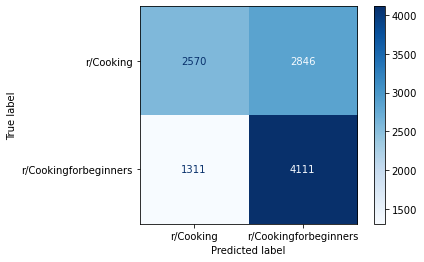

In [33]:
ConfusionMatrixDisplay.from_estimator(pipe1,X_test,y_test,cmap='Blues');

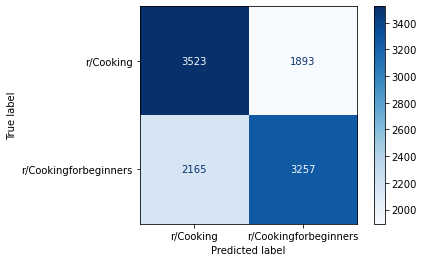

In [177]:
ConfusionMatrixDisplay.from_estimator(rsc.best_estimator_,X_test,y_test,cmap='Blues');

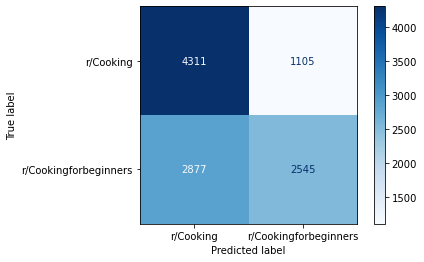

In [176]:
ConfusionMatrixDisplay.from_estimator(rsc2.best_estimator_,X_test,y_test,cmap='Blues');

This, if nothing else, is interesting. The logistic model was *pretty* good at identifying Cooking for Beginners posts- 76% of C4B posts were correctly labeled as such. But they were only able to correctly identify 47.5% of r/Cooking posts correctly as Cooking posts.

The random forest splits it in the model and identifys 65% of cooking posts correctly versus 60% of Cooking for Beginners posts

And the ExtraTreesClassifier correctly classifies 80% of Cooking posts, while only 47% of Cooking for Beginners posts. Further consideration must be given for why this is the case- and perhaps looking at feature-importance will help in that regard

First, we're going to look at AdaBoost, though, and see if it helps

In [14]:
pipe3 = Pipeline([
    ('cv',CountVectorizer(strip_accents='ascii',max_features=1000,max_df=0.8)),
    ('abc',AdaBoostClassifier(n_estimators=800,random_state=815))
])

Just a barebone model, to see if it works- if it does particularly well, we'll try playing around with features

In [15]:
pipe3.fit(X_train,y_train)

Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.8, max_features=1000,
                                 strip_accents='ascii')),
                ('abc',
                 AdaBoostClassifier(n_estimators=800, random_state=815))])

In [16]:
pipe3.score(X_test,y_test)

0.6256689426093375

In [78]:
pipe1.score(X_train,y_train), rsc.score(X_train,y_train), rsc2.score(X_train,y_train), pipe3.score(X_train,y_train)

(0.7418799212598425,
 0.8768454724409449,
 0.8850578248031497,
 0.6655696358267716)

The interesting thing is that none of these are as super-overfit as some models that have 99% on train, and lower on the test. But given what I see, I'd like to perhaps increase the number of estimators a lot on the AdaBoost, and see if it can figure out some of the more tricky problems- and perhaps also mess with the vectorizer somewhat

In [17]:
pipe4 = Pipeline([
    ('cv',CountVectorizer(strip_accents='ascii',max_features=1000,max_df=0.8)),
    ('abc',AdaBoostClassifier(n_estimators=7500,random_state=815))
])
pipe4.fit(X_train,y_train)
pipe4.score(X_train,y_train), pipe4.score(X_test,y_test)

(0.6986958661417323, 0.6158885403210924)

Amusingly, this is worse than before.

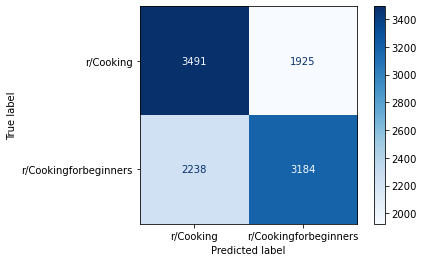

In [34]:
ConfusionMatrixDisplay.from_estimator(pipe4,X_test,y_test,cmap='Blues');

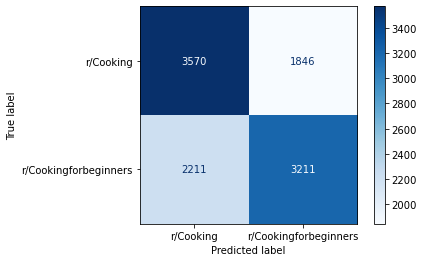

In [35]:
ConfusionMatrixDisplay.from_estimator(pipe3,X_test,y_test,cmap='Blues');

In [27]:
with open('C:/Users/Karthik/Documents/DSIProj3largedata/RandForestrcvpickle.pkl','rb') as x:
    rsc = pickle.load(x)

In [28]:
with open('C:/Users/Karthik/Documents/DSIProj3largedata/ExtraPickledForestrcv.pkl','rb') as x:
    rsc2 = pickle.load(x)

In [38]:
rsc2.best_estimator_

Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.8, max_features=1000,
                                 strip_accents='ascii')),
                ('etc',
                 ExtraTreesClassifier(criterion='entropy', min_samples_split=3,
                                      n_estimators=200, n_jobs=-1,
                                      random_state=815))])

In [29]:
rfcpreds = pd.DataFrame(rsc.best_estimator_.predict(X_test),columns=['randforestpred'])
efcpreds = pd.DataFrame(rsc2.best_estimator_.predict(X_test),columns=['extforestpred'])
logpreds = pd.DataFrame(pipe1.predict(X_test),columns=['logregpred'])


In [30]:
df_classes = pd.concat([pd.DataFrame(list(X_test),columns=['selftext']),
                        pd.DataFrame(list(y_test),columns=['ytrue']),
                        logpreds,rfcpreds,efcpreds],axis=1)

In [31]:
lrtrue = df_classes['ytrue'] == df_classes['logregpred']
rftrue = df_classes['ytrue'] == df_classes['randforestpred']
eftrue = df_classes['ytrue'] == df_classes['extforestpred']

In [32]:
df_classes[(~lrtrue) & (~rftrue) & (~eftrue)&(df_classes['selftext']=='')].shape,df_classes[(~lrtrue) & (~rftrue) & (~eftrue)].shape

((404, 5), (1596, 5))

404 out of 1596 errors were a given because the self-text was blank- CookingforBeginners had more blank-text options

In [33]:
df_classes[(lrtrue) & (rftrue) & (eftrue)&(df_classes['selftext']=='')].shape, df_classes[(lrtrue) & (rftrue) & (eftrue)].shape

((1268, 5), (4209, 5))

And 1268/4209 of ones that all got right were blank text. To be more explicit, 76% of blank self-texts are from C4B, and guesses on blanks made up 30% of (universal) correct guesses on the test set came from blank text, versus 25% of (universal) incorrect guesses

In [34]:
df_classes[(~lrtrue) & (rftrue) & (eftrue)&(df_classes['selftext']!='')].shape

(1201, 5)

In [35]:
df_classes[(lrtrue) & (~rftrue) & (eftrue)&(df_classes['selftext']!='')].shape

(364, 5)

In [36]:
df_classes[(lrtrue) & (rftrue) & (~eftrue)&(df_classes['selftext']!='')].shape

(1092, 5)

In [37]:
print(f'''LogReg missed predictions : {round((1-pipe1.score(X_test,y_test))*len(y_test))}
\nRandForest missed predictions: {round((1-rsc.best_estimator_.score(X_test,y_test))*len(y_test))}
\nExtraForest missed predictions: {round((1-rsc2.best_estimator_.score(X_test,y_test))*len(y_test))}
''')

LogReg missed predictions : 4157

RandForest missed predictions: 4058

ExtraForest missed predictions: 3982



To put this together, 32% of the logistic regression's misses (excluding selftext='') were caught by the other two, 30.5% of Extra Trees, but only 10% of Random Forest! We'll look at some random sentences each estimator missed that the other 2 got, but all this suggests there might be some gain from a VotingClassifier

In [77]:
pd.set_option('display.max_colwidth', None)

In [159]:
df_classes[(~lrtrue) & (rftrue) & (eftrue)&(df_classes['selftext']!='')].sample(5,random_state=27)

,selftext,ytrue,logregpred,randforestpred,extforestpred
1602,"I’m going to grill a red wine and garlic marinated chukar this weekend and was wondering as to what would go well with it (besides asparagus, green beans and rice lol). Any suggestions are welcome!",r/Cooking,r/Cookingforbeginners,r/Cooking,r/Cooking
2621,"I’ve seen michiu named in some cooking recipes like chicken fish or pork, i’m wondering what it’s mainly used for. i usually use red wine for cooking beef and red meat but i’ve run out and am wondering if i can substitute michiu (someone gifted me a bottle recently) and will it have the same result? if not what can i use michiu for?",r/Cooking,r/Cookingforbeginners,r/Cooking,r/Cooking
6861,"This could be an injury accident (cutting yourself, burning, etc.) or less lethal mistakes (forgetting stuff on stove, leaving raw meat out way too long, etc.). \n\nFor me, it was cutting myself early on when I started cooking a lot. Once I wised up and my knife skills became better, burning myself became the problem. Still do it every now and then, especially now that I have a gas range.",r/Cooking,r/Cookingforbeginners,r/Cooking,r/Cooking
3933,"[https://imgur.com/a/pNVlMj3](https://imgur.com/a/pNVlMj3)\n\nI know most people don't like crispy edges on their lasagna as some of us do, but this takes it to a ***whole other level***. I may have to try it.",r/Cooking,r/Cookingforbeginners,r/Cooking,r/Cooking
10311,"Hi, so I am having an issue. Before I make potato spears I make my seasoning for them, then add olive oil and toss the potatoes before putting them in the oven at 375-400. I am having an issue where the potatoes aren't burning, but the seasoning on the potatoes is burning, and I can't figure out why. Any ideas on how to prevent something like this from happening?",r/Cooking,r/Cookingforbeginners,r/Cooking,r/Cooking


In [160]:
df_classes[(lrtrue) & (~rftrue) & (eftrue)&(df_classes['selftext']!='')].sample(5,random_state=83)

,selftext,ytrue,logregpred,randforestpred,extforestpred
5008,"Simply 1-3 chicken breasts, would you need bottle of canola oil? Or could you do it in a pan with a small enough amount that you can pour into the trash after it cools? For example for chicken parm...",r/Cookingforbeginners,r/Cookingforbeginners,r/Cooking,r/Cookingforbeginners
1176,"For purposes of not looking too tacky to your female date, what should be cooked by you and what things can safely just be used prepackaged?\n\n&amp;#x200B;\n\nSo like noodles for example. Why should I not just use instant ramen, isn't it as cheap and as good tasting in many cases as cooking noodles myself? Or would that look too tacky? And then just cook the meat/veggies to throw on top",r/Cookingforbeginners,r/Cookingforbeginners,r/Cooking,r/Cookingforbeginners
2263,"My mom makes a dish that included baby portabella mushrooms, bell peppers, and red onion. These are cooked in the same pan as cubed chicken. Her recipe is not exact and she really just eyeballs the portions and cooking time because she knows what she’s doing...I do not. In what order should I bring the veggies and chicken together so that nothing is burnt to a crisp and the chicken is cooked through? The whole pan will include 4-5 breasts of chicken (cubed), one bell pepper, one red onion, and an 8 oz package of baby portabella mushrooms.",r/Cookingforbeginners,r/Cookingforbeginners,r/Cooking,r/Cookingforbeginners
5619,"Like many other home cooks who struggle to get a good hard sear on their meat without setting off their over-sensitive fire alarm in their apartment, Frank Prinsinzano's Brown Butter Method is a must learn. It still gets you a beautiful brown crust, but its done at medium heat rather than high heat, so it never smokes. \n\nTo start, melt a lot of butter in a stainless steel pan. Once the water cooks out of the butter and it stops sizzling, add in your meat, some basting herbs, and garlic cloves. Begin basting immedietely. The meat should have a nice steady sizzle the entire time but the butter should never smoke. Keep the heat on medium and if there's any hint its starting to burn, move the pan off the heat for a bit. Flip every few minutes continously basting until it reaches the desired internal temp.\n\nAnother benefit of this over the classic ""sear in a smoking hot pan"" is that you can more generously season the meat without worrying about pepper or garlic powder burning. You get a glorious fond and plenty of leftover brown butter to cook any veggies in while the meat rests. \n\nVideo Recipe of the method in action here: https://youtu.be/vo_dFDOI5e0\nHe also explains it in one of the highlights on his Instagram: https://www.instagram.com/frankprisinzano/?hl=en",r/Cooking,r/Cooking,r/Cookingforbeginners,r/Cooking
8280,"I'm making big cakes, so I want it to be made possible that they be stored 3 to 5 days in the fridge and they can still be as soft as possible. \n\nWhat I'm adding:\n\negg yolks, sugar, butter, water, all purpose flour, baking flour, salt\n\nmeringue with only sugar\n\nI then just fold them together. Taste is... okay. Not yet the best. It was my first time. It's definitely soft, but very dense. I want it to last and be even less dense and more fluffier.",r/Cookingforbeginners,r/Cookingforbeginners,r/Cooking,r/Cookingforbeginners


In [163]:
df_classes[(lrtrue) & (rftrue) & (~eftrue)&(df_classes['selftext']!='')].sample(5,random_state=96)

,selftext,ytrue,logregpred,randforestpred,extforestpred
9019,[removed],r/Cookingforbeginners,r/Cookingforbeginners,r/Cookingforbeginners,r/Cooking
7848,"\nCome watch kalala make baklava, bread, tomato soup, and grilled cheese sandwiches. \n\n\n[kalala’s kitchen](www.twitch.tv/kalalaskitchen)",r/Cooking,r/Cooking,r/Cooking,r/Cookingforbeginners
8793,Hey! There's a killer deal on roma tomatoes right now and I want to grab them! If i freeze them whole will they hold up okay? They'll be used for sauce,r/Cooking,r/Cooking,r/Cooking,r/Cookingforbeginners
2724,[removed],r/Cookingforbeginners,r/Cookingforbeginners,r/Cookingforbeginners,r/Cooking
9916,[removed],r/Cookingforbeginners,r/Cookingforbeginners,r/Cookingforbeginners,r/Cooking


In [79]:
df_classes[(~lrtrue) & (~rftrue) & (~eftrue)&(df_classes['selftext']!='')].sample(5,random_state=9)

,selftext,ytrue,logregpred,randforestpred,extforestpred
324,I was cooking for my grandma’s birthday the other day. We were making Cortusolini with Magini sauce when I accidentally added too much beanut putter. I meant peanut butter sorry I have dyslexia. The dish came out horribly ruined and gave my grandma food poisoning. She passed away and the cops suspect foul play for poisoning or something like that. How can I prove that I didn’t do it? I’m 240 pounds and 6’3 by the way.,r/Cookingforbeginners,r/Cooking,r/Cooking,r/Cooking
2414,"So I am trying to figure out why I dislike my cooking. I guess my husband is bias. It doesn't matter what I cook, I don't want to eat it. Any tips",r/Cooking,r/Cookingforbeginners,r/Cookingforbeginners,r/Cookingforbeginners
3749,Hi all I have been getting better and better at cooking. I can make some pasta dishes and a few different things here and there. I’m looking for some new ideas. Has anyone got any solid meal lists that everyone should know how to make?,r/Cookingforbeginners,r/Cooking,r/Cooking,r/Cooking
4610,"Just made a cake and the recipe said I can put the cinnamon powdered filling on top, but I shoulda done that before putting it in the oven. I put it on after and I forgot that there was flour in it. What can I do? It’s mixed into the other toppings.",r/Cooking,r/Cookingforbeginners,r/Cookingforbeginners,r/Cookingforbeginners
8110,"So I'm currently away from home, so a lot of kitchen utensils I had access to is no longer available to me. I was wondering if a recipe called for a baking dish, could I replace said baking dish with a baking pan? If so, is there any difference in time when cooking something? For example, I'm cooking baked mac and cheese for a friend but I wasn't sure if I would need to lower the time called for in the recipe. I've tried looking up information on this but all I've gotten so far is what I should cook in a pan versus what I should cook in a dish. Thanks in advanced for any help.",r/Cookingforbeginners,r/Cooking,r/Cooking,r/Cooking


In [38]:
vc = VotingClassifier([
    ('logreg',pipe1),
    ('randfor',rsc.best_estimator_),
    ('extfor',rsc2.best_estimator_)
],voting='soft',n_jobs=-1)

In [39]:
vc.fit(X_train,y_train)

VotingClassifier(estimators=[('logreg',
                              Pipeline(steps=[('cv',
                                               CountVectorizer(strip_accents='unicode')),
                                              ('logreg',
                                               LogisticRegression())])),
                             ('randfor',
                              Pipeline(steps=[('cv',
                                               CountVectorizer(max_df=0.8,
                                                               max_features=1000,
                                                               ngram_range=(1,
                                                                            2),
                                                               strip_accents='ascii')),
                                              ('rfc',
                                               RandomForestClassifier(min_samples_leaf=2,
                                             

In [40]:
vc.score(X_test,y_test)

0.6451374792397121

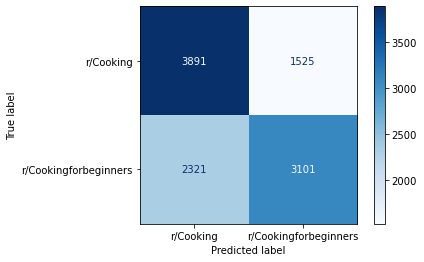

In [178]:
ConfusionMatrixDisplay.from_estimator(vc,X_test,y_test,cmap='Blues');

In [179]:
vc2 = VotingClassifier([
    ('logreg',pipe1),
    ('randfor',rsc.best_estimator_),
    ('extfor',rsc2.best_estimator_)
],voting='hard',n_jobs=-1)

In [180]:
vc2.fit(X_train,y_train)

VotingClassifier(estimators=[('logreg',
                              Pipeline(steps=[('cv',
                                               CountVectorizer(strip_accents='unicode')),
                                              ('logreg',
                                               LogisticRegression())])),
                             ('randfor',
                              Pipeline(steps=[('cv',
                                               CountVectorizer(max_df=0.8,
                                                               max_features=1000,
                                                               ngram_range=(1,
                                                                            2),
                                                               strip_accents='ascii')),
                                              ('rfc',
                                               RandomForestClassifier(min_samples_leaf=2,
                                             

In [181]:
vc2.score(X_test,y_test)

0.6334194500830411

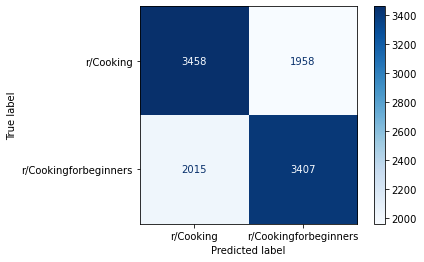

In [184]:
ConfusionMatrixDisplay.from_estimator(vc2,X_test,y_test,cmap='Blues')

In [46]:
df_rf_ftimp = pd.DataFrame(rsc.best_estimator_.steps[1][1].feature_importances_,
             columns=['ft_imp'],index=rsc.best_estimator_.steps[0][1].get_feature_names_out())

In [49]:
df_rf_ftimp.sort_values(by='ft_imp',ascending=False).head(10)

,ft_imp
removed,0.029470
and,0.014833
the,0.013500
to,0.013281
of,0.011026
it,0.010756
for,0.009200
in,0.008400
is,0.007713
with,0.007521


In [50]:
df_ef_ftimp = pd.DataFrame(rsc2.best_estimator_.steps[1][1].feature_importances_,
             columns=['ft_imp'],index=rsc2.best_estimator_.steps[0][1].get_feature_names_out())

In [51]:
df_ef_ftimp.sort_values(by='ft_imp',ascending=False).head(10)

,ft_imp
removed,0.014796
to,0.004962
of,0.004900
and,0.004802
it,0.004711
the,0.004654
for,0.004434
is,0.004352
in,0.004322
with,0.004244


In [63]:
df_lr_ftimp = pd.DataFrame(pipe1[1].coef_.T,
             columns=['ft_imp'],index=pipe1[0].get_feature_names_out())

In [75]:
df_lr_ftimp.sort_values(by='ft_imp',ascending=False).head(10)

,ft_imp
cookingforbeginners,3.615796
beginners,2.457308
packets,1.696562
myweekendplan,1.692092
beginner,1.552283
unsweetened,1.467371
basics,1.387838
optional,1.373800
thickness,1.328635
takeout,1.318424


In [66]:
pipe1

Pipeline(steps=[('cv', CountVectorizer(strip_accents='unicode')),
                ('logreg', LogisticRegression())])